In [108]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import butter, sosfiltfilt, sosfreqz  
from scipy.io import loadmat
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc

from sklearn.decomposition import FastICA

In [128]:
data_dir = 'data'
bc4_2a_raw_name = 'bci_competition_4_2a_raw'
bc3_3a_raw_name = 'bci_competition_3_3a_raw'

bc4_2a_processed_name = 'bci_competition_4_2a_processed'
bc3_3a_processed_name = 'bci_competition_3_3a_processed'

bc4_2a_raw_dir = os.path.join(data_dir, bc4_2a_raw_name)
bc4_2a_processed_dir = os.path.join(data_dir, bc4_2a_processed_name)

bc3_3a_raw_dir = os.path.join(data_dir, bc3_3a_raw_name)
bc3_3a_processed_dir = os.path.join(data_dir, bc3_3a_processed_name)


In [117]:
## Define constants
num_subjects = 9
num_channels = 22
sampling_f = 250  ## Hz
baseline_duration = 2  ## seconds
motor_imagery_start = 3.5  ## seconds after trial begins
motor_imagery_end = 5.5  ## seconds after trial begins
motor_imagery_trial_duration = int(motor_imagery_end - motor_imagery_start)  ## seconds

## Create filter
order = 6
lower_passband = 7
upper_passband = 30
sos = butter(order, 
             [lower_passband, upper_passband], 
             analog = False, 
             btype = 'band', 
             output = 'sos', 
             fs = sampling_f)

In [122]:
for i in range(1, 10):

    subject_name = 'A0' + str(i) + 'T'
    subject_path = os.path.join(bc4_2a_raw_dir, subject_name + '.gdf')
    subject_mne = mne.io.read_raw_gdf(subject_path)
    raw_data = subject_mne.get_data()[:22]
    X = raw_data.T  # Observations (mixed signal)
    ica = FastICA(n_components=22)
    S_ = ica.fit_transform(X)  # Recovered signals
    A_ = ica.mixing_  # Get estimated mixing matrix
    raw_data = S_.T
    
    
    ## Access annotations
    annotations = subject_mne.annotations
    annotations_list = list(annotations)
    
    ## Convert annotation dictionary into lists
    descriptions = []
    onsets = []

    for i in range(len(annotations_list) - 1):
        
        description_cur = annotations_list[i]['description']
        description_next = annotations_list[i + 1]['description']
        
        ## Check if the current trial is valid and has a known cue
        if description_cur == '768' and description_next in ['769', '770', '771', '772']:    
            onsets.append(annotations_list[i]['onset'])
            descriptions.append(int(description_next))
    
    descriptions = np.array(descriptions)
    onsets = np.array(onsets)
    
    ## Process by onsets to create epochs
    num_valid_trials = onsets.shape[0]

    ## Initialize processed data array
    processed_motor_imagery_data = np.zeros((num_valid_trials,
                                             num_channels,
                                             motor_imagery_trial_duration * sampling_f))
    
    for idx_trial in range(num_valid_trials):
        
        ## Epoching
        onset_time = onsets[idx_trial]
        onset_index = int(onset_time * sampling_f)
        
        motor_imagery_start_time = onset_time + motor_imagery_start        
        motor_imagery_start_index = int(motor_imagery_start_time * sampling_f)
        motor_imagery_end_index = motor_imagery_start_index + motor_imagery_trial_duration * sampling_f
        
        motor_imagery_data = raw_data[:, motor_imagery_start_index:motor_imagery_end_index]
        
        ## DC correction
        motor_imagery_data_mean = np.mean(motor_imagery_data, axis=1).reshape((num_channels, 1))
        motor_imagery_data = motor_imagery_data - motor_imagery_data_mean
        
        ## Filtering (band pass to 7~30 Hz)
        motor_imagery_data = sosfiltfilt(sos, motor_imagery_data, axis=1)
        
        ## Baseline correction
        baseline_end_index = onset_index + baseline_duration * sampling_f
        
        baseline_data = raw_data[:, onset_index:baseline_end_index]
        baseline_data_mean = np.mean(baseline_data, axis=1).reshape((num_channels, 1))
        motor_imagery_data = motor_imagery_data - baseline_data_mean
        
        ## Store processed motor imagery data
        processed_motor_imagery_data[idx_trial, :, :] = motor_imagery_data
    
    
    ## Export processed motor imagery data
    processed_subject_path = os.path.join(bc4_2a_processed_dir, subject_name + '.npz')
    np.savez(processed_subject_path, 
             processed_motor_imagery_data=processed_motor_imagery_data, 
             descriptions=descriptions, 
             onsets=onsets)
    
    print('Finished processing subject dataset ', idx_subject)


Extracting EDF parameters from /Users/oliviazhao/Documents/GitHub/COGS-189-Final-Project/data/bci_competition_4_2a_raw/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


/Users/oliviazhao/opt/anaconda3/lib/python3.8/site-packages/mne/io/edf/edf.py:1131: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/Users/oliviazhao/opt/anaconda3/lib/python3.8/contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Finished processing subject dataset  1
Extracting EDF parameters from /Users/oliviazhao/Documents/GitHub/COGS-189-Final-Project/data/bci_competition_4_2a_raw/A02T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


/Users/oliviazhao/opt/anaconda3/lib/python3.8/site-packages/mne/io/edf/edf.py:1131: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/Users/oliviazhao/opt/anaconda3/lib/python3.8/contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Finished processing subject dataset  1
Extracting EDF parameters from /Users/oliviazhao/Documents/GitHub/COGS-189-Final-Project/data/bci_competition_4_2a_raw/A03T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


/Users/oliviazhao/opt/anaconda3/lib/python3.8/site-packages/mne/io/edf/edf.py:1131: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/Users/oliviazhao/opt/anaconda3/lib/python3.8/contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Finished processing subject dataset  1
Extracting EDF parameters from /Users/oliviazhao/Documents/GitHub/COGS-189-Final-Project/data/bci_competition_4_2a_raw/A04T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


/Users/oliviazhao/opt/anaconda3/lib/python3.8/site-packages/mne/io/edf/edf.py:1131: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/Users/oliviazhao/opt/anaconda3/lib/python3.8/contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Finished processing subject dataset  1
Extracting EDF parameters from /Users/oliviazhao/Documents/GitHub/COGS-189-Final-Project/data/bci_competition_4_2a_raw/A05T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


/Users/oliviazhao/opt/anaconda3/lib/python3.8/site-packages/mne/io/edf/edf.py:1131: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/Users/oliviazhao/opt/anaconda3/lib/python3.8/contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Finished processing subject dataset  1
Extracting EDF parameters from /Users/oliviazhao/Documents/GitHub/COGS-189-Final-Project/data/bci_competition_4_2a_raw/A06T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


/Users/oliviazhao/opt/anaconda3/lib/python3.8/site-packages/mne/io/edf/edf.py:1131: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/Users/oliviazhao/opt/anaconda3/lib/python3.8/contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Finished processing subject dataset  1
Extracting EDF parameters from /Users/oliviazhao/Documents/GitHub/COGS-189-Final-Project/data/bci_competition_4_2a_raw/A07T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


/Users/oliviazhao/opt/anaconda3/lib/python3.8/site-packages/mne/io/edf/edf.py:1131: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/Users/oliviazhao/opt/anaconda3/lib/python3.8/contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Finished processing subject dataset  1
Extracting EDF parameters from /Users/oliviazhao/Documents/GitHub/COGS-189-Final-Project/data/bci_competition_4_2a_raw/A08T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


/Users/oliviazhao/opt/anaconda3/lib/python3.8/site-packages/mne/io/edf/edf.py:1131: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/Users/oliviazhao/opt/anaconda3/lib/python3.8/contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Finished processing subject dataset  1
Extracting EDF parameters from /Users/oliviazhao/Documents/GitHub/COGS-189-Final-Project/data/bci_competition_4_2a_raw/A09T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


/Users/oliviazhao/opt/anaconda3/lib/python3.8/site-packages/mne/io/edf/edf.py:1131: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/Users/oliviazhao/opt/anaconda3/lib/python3.8/contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Finished processing subject dataset  1


In [129]:
## Define constants
num_subjects = 3
num_channels = 60
sampling_f = 250  ## Hz
baseline_duration = 2  ## seconds
motor_imagery_start = 4.5  ## seconds after trial begins
motor_imagery_end = 6.5  ## seconds after trial begins
motor_imagery_trial_duration = int(motor_imagery_end - motor_imagery_start)  ## seconds

## Note: for the 3_3a dataset, the training time span is technically 3s to 7s.
##   but since no break is given, and reaction time is not accounted for, we use 4.5s to 6.5s, 
##   making a duration of 2s, same as 4_2a 

In [130]:
## Create filter
order = 6
lower_passband = 7
upper_passband = 30
sos = butter(order, 
             [lower_passband, upper_passband], 
             analog = False, 
             btype = 'band', 
             output = 'sos', 
             fs = sampling_f)

In [131]:
subject_dir_names = ['subject1_k3b', 'subject2_k6b', 'subject3_l1b']


for idx_subject, subject_dir_name in enumerate(subject_dir_names):
    idx_subject += 1
    
    ## Load subject dataset with MNE
    subject_dir = os.path.join(bc3_3a_raw_dir, subject_dir_name)
    subject_name = 'bc3_3a_s' + str(idx_subject)
    subject_path_gdf = os.path.join(subject_dir, subject_name + '.gdf')
    subject_mne = mne.io.read_raw_gdf(subject_path_gdf)
    raw_data = subject_mne.get_data()
    
    X = raw_data.T  # Observations (mixed signal)
    ica = FastICA()
    S_ = ica.fit_transform(X)  # Recovered signals
    A_ = ica.mixing_  # Get estimated mixing matrix
    raw_data = S_.T
    
    
    ## Access annotations
    annotations = subject_mne.annotations
    annotations_list = list(annotations)
    
    ## Convert annotation dictionary into lists
    descriptions = []
    onsets = []
    onset_trial = -1
    valid_trial = True
    total_trial_count = 0
    rejected_trial_count = 0
    unknown_cue_count = 0
    
    for i in range(len(annotations_list)):
        
        description_cur = annotations_list[i]['description']
        onset_cur = annotations_list[i]['onset']
        
        if description_cur == '768':
            valid_trial = True
            onset_trial = onset_cur
            total_trial_count += 1
            
        elif description_cur == '1023':
            valid_trial = False
            rejected_trial_count += 1
            
        elif valid_trial: 
            if description_cur in ['769', '770', '771', '772']:
                descriptions.append(int(description_cur))
                onsets.append(onset_trial)
            elif description_cur == '783':
                unknown_cue_count += 1
            
    descriptions = np.array(descriptions)
    onsets = np.array(onsets)
    num_valid_trials = onsets.shape[0]
    
    print('Finished processing annotation for subject', idx_subject)
    print('\tTotoal trial count: ', total_trial_count)
    print('\tRejected trial count: ', rejected_trial_count)
    print('\tUnknown cue count: ', unknown_cue_count)
    print('\tNumber of valid trials: ', num_valid_trials)
    
    ## Process by onsets to create epochs
    
    ## Initialize processed data array
    processed_motor_imagery_data = np.zeros((num_valid_trials, 
                                            num_channels,
                                            int(motor_imagery_trial_duration * sampling_f)))
    
    for idx_trial in range(num_valid_trials):
        
        ## Epoching
        onset_time = onsets[idx_trial]
        onset_index = int(onset_time * sampling_f)
        
        motor_imagery_start_time = onset_time + motor_imagery_start        
        motor_imagery_start_index = int(motor_imagery_start_time * sampling_f)
        motor_imagery_end_index = motor_imagery_start_index + int(motor_imagery_trial_duration * sampling_f)
      
        motor_imagery_data = raw_data[:, motor_imagery_start_index:motor_imagery_end_index]
        
        ## DC correction
        motor_imagery_data_mean = np.mean(motor_imagery_data, axis=1).reshape((num_channels, 1))
        motor_imagery_data = motor_imagery_data - motor_imagery_data_mean
        
        ## Filtering (band pass to 7~30 Hz)
        motor_imagery_data = sosfiltfilt(sos, motor_imagery_data, axis=1)
        
        ## Baseline correction
        baseline_end_index = onset_index + baseline_duration * sampling_f
        
        baseline_data = raw_data[:, onset_index:baseline_end_index]
        baseline_data_mean = np.mean(baseline_data, axis=1).reshape((num_channels, 1))
        motor_imagery_data = motor_imagery_data - baseline_data_mean
        
        ## Store processed motor imagery data
        processed_motor_imagery_data[idx_trial, :, :] = motor_imagery_data
    
    
    ## Export processed motor imagery data
    processed_subject_path = os.path.join(bc3_3a_processed_dir, subject_name + '.npz')
    np.savez(processed_subject_path, 
             processed_motor_imagery_data=processed_motor_imagery_data, 
             descriptions=descriptions, 
             onsets=onsets)
    
    print('Finished processing subject dataset ', idx_subject)

Extracting EDF parameters from /Users/oliviazhao/Documents/GitHub/COGS-189-Final-Project/data/bci_competition_3_3a_raw/subject1_k3b/bc3_3a_s1.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
#  1, #  2, #  3, #  4, #  5, #  6, #  7, #  8, #  9, # 10, # 11, # 12, # 13, # 14, # 15, # 16, # 17, # 18, # 19, # 20, # 21, # 22, # 23, # 24, # 25, # 26, # 27, # 28, # 29, # 30, # 31, # 32, # 33, # 34, # 35, # 36, # 37, # 38, # 39, # 40, # 41, # 42, # 43, # 44, # 45, # 46, # 47, # 48, # 49, # 50, # 51, # 52, # 53, # 54, # 55, # 56, # 57, # 58, # 59, # 60
Creating raw.info structure...
Finished processing annotation for subject 1
	Totoal trial count:  360
	Rejected trial count:  62
	Unknown cue count:  149
	Number of valid trials:  149
Finished processing subject dataset  1
Extracting EDF parameters from /Users/oliviazhao/Documents/GitHub/COGS-189-Final-Project/data/bci_competition_3_3a_raw/subject2_k6b/

In [ ]:
raw_data.shape
ica = FastICA(n_components=3)
S_ = ica.fit_transform(raw_data.T)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

In [ ]:
# dataset = processed_dataset_npz['processed_motor_imagery_data']
# new_dataset = []
# for i in range(25):
#     new_dataset.append(list(dataset[i].flatten()))
# new_dataset = np.array(new_dataset)
    

In [ ]:
new_dataset.shape

In [ ]:
labels = processed_dataset_npz["descriptions"]


In [ ]:
X.shape

In [ ]:

ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)


In [40]:
S_.shape

(25, 22)

In [4]:
import numpy as np
np.random.seed(0)
from scipy import signal
from scipy.io import wavfile
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [70]:
np.random.seed(23)

# Number of samples
ns = np.linspace(0, 200, 1000)

S = np.array([np.sin(ns * 1),
              signal.sawtooth(ns * 1.9),
              np.random.random(len(ns))]).T

# Mixing matrix
A = np.array([[0.5, 1, 0.2],
              [1, 0.5, 0.4],
              [0.5, 0.8, 1]])

# Mixed signal matrix
X = S.dot(A).T

In [82]:
S.shape
A.shape
X.shape
ns.shape

(1000,)

In [5]:
def g(x):
    return np.tanh(x)

def g_der(x):
    return 1 - g(x) * g(x)

In [ ]:
S = ica(X, iterations=10)
# actual = mix_sources([s1,s2,s3])
# plot_mixture_sources_predictions(X, [s1, s2, s3], S)

In [75]:
subject_name = 'A01T.gdf'
subject_path = os.path.join(bc4_2a_raw_dir, subject_name)
subject_mne = mne.io.read_raw_gdf(subject_path)
raw_data = subject_mne.get_data()[:22]
X = raw_data  # Observations (mixed signal)

Extracting EDF parameters from /Users/oliviazhao/Documents/GitHub/COGS-189-Final-Project/data/bci_competition_4_2a_raw/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


/Users/oliviazhao/opt/anaconda3/lib/python3.8/site-packages/mne/io/edf/edf.py:1131: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/Users/oliviazhao/opt/anaconda3/lib/python3.8/contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


In [98]:
# https://github.com/akcarsten/Independent_Component_Analysis

In [60]:
def whiten(x):
    
    # center
    mean = np.mean(x, axis=1, keepdims=True)
    centered =  x - mean
    
    # covariance matrix
    coVarM = np.cov(centered)

    # Single value decomposition
    U, S, V = np.linalg.svd(coVarM)

    # Calculate diagonal matrix of eigenvalues
    d = np.diag(1.0 / np.sqrt(S))

    # Calculate whitening matrix
    whiteM = np.dot(U, np.dot(d, U.T))

    # Project onto whitening matrix
    Xw = np.dot(whiteM, X)

    return Xw, whiteM

In [61]:
def fastIca(signals,  alpha = 1, thresh=1e-8, iterations=1000):
    m, n = signals.shape

    # Initialize random weights
    W = np.random.rand(m, m)

    for c in range(m):
            w = W[c, :].copy().reshape(m, 1)
            w = w / np.sqrt((w ** 2).sum())

            i = 0
            lim = 100
            while ((lim > thresh) & (i < iterations)):

                # Dot product of weight and signal
                ws = np.dot(w.T, signals)

                # Pass w*s into contrast function g
                wg = np.tanh(ws * alpha).T

                # Pass w*s into g prime
                wg_ = (1 - np.square(np.tanh(ws))) * alpha

                # Update weights
                wNew = (signals * wg.T).mean(axis=1) - wg_.mean() * w.squeeze()

                # Decorrelate weights              
                wNew = wNew - np.dot(np.dot(wNew, W[:c].T), W[:c])
                wNew = wNew / np.sqrt((wNew ** 2).sum())

                # Calculate limit condition
                lim = np.abs(np.abs((wNew * w).sum()) - 1)

                # Update weights
                w = wNew

                # Update counter
                i += 1

            W[c, :] = w.T
    return W

In [99]:
# Whiten mixed signals
Xw, whiteM = whiten(X)

In [100]:
W = fastIca(Xw)

In [126]:
# ica
np.dot(W,Xw).shape

(22, 672528)

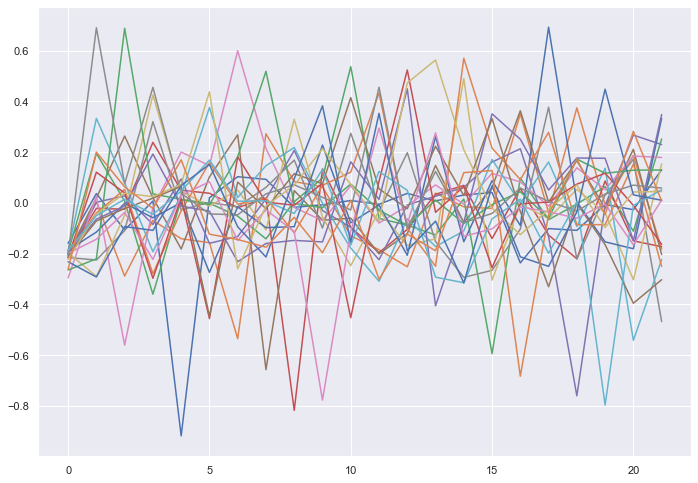

In [116]:
plt.plot(W)

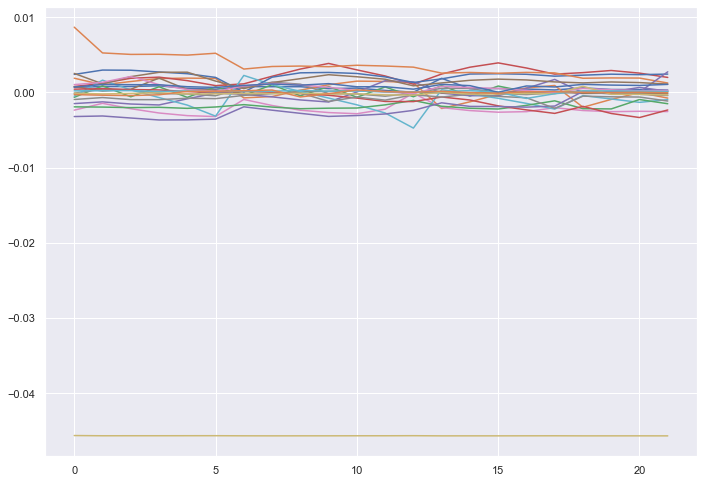

In [115]:
# sklearn fastica
plt.plot(A_)